In [1]:
import shutil
import os

from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = Chroma(
    embedding_function=embedding_function, 
    collection_name="income_tax_collection",
    persist_directory="./income_tax_collection"
)
retriever = vector_store.as_retriever(search_kwargs={"k": 3})

In [2]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

graph_builder = StateGraph(AgentState)

In [3]:
def retrieve(state: AgentState):
    query = state['query']
    docs = retriever.invoke(query)
    return {'context': docs}

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

In [5]:
from langchain import hub

generate_prompt = hub.pull("rlm/rag-prompt")

def generate(state: AgentState):
    context = state['context']
    query = state['query']
    rag_chain = generate_prompt | llm
    response = rag_chain.invoke({'question': query, 'context': context})
    return {'answer': response}

/Users/hippoo/Desktop/SoMA/e-learning/langgraph/.venv/lib/python3.13/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [6]:
from langchain import hub
from typing import Literal

doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['generate', 'rewrite']:
    query = state['query']
    context = state['context']
    print(f'context: {context}')
    doc_relevance_chain = doc_relevance_prompt | llm
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})
    print(f'response: {response}')
    if response['Score'] == 1:
        return 'generate'
    return 'rewrite'


/Users/hippoo/Desktop/SoMA/e-learning/langgraph/.venv/lib/python3.13/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [7]:
query  = '연봉 5천만원 직장인의 소득세는?'

In [8]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

dictionary = ['사람과 관련된 표현 -> 거주자']

rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요.
사전: {dictionary}
질문: {{query}}
""")

def rewrite(state: AgentState):
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    response = rewrite_chain.invoke({'query': query})
    return {'query': response}

In [9]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)

In [10]:
from langgraph.graph import START, END


graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges('retrieve', check_doc_relevance)
graph_builder.add_edge('rewrite', 'retrieve')
graph_builder.add_edge('generate', END)

In [11]:
graph = graph_builder.compile()

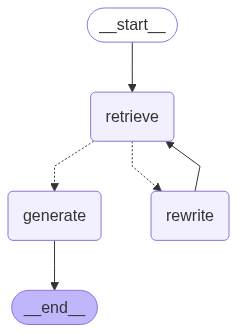

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
initial_state = {'query': query}
graph.invoke(initial_state)

context: [Document(metadata={'source': './documents/income_tax.txt'}, page_content='|--------------------|---------------------------------------------|\n| 5,000만원 이하      | 총 급여액의 100분의 70                      |\n| 5,000만원 초과 1천 5,000만원 이하 | 3,500만원 + (5,000만원을 초과하는 금액의 100분의 40) |\n| 1천 5,000만원 초과 4천 5,000만원 이하 | 7,500만원 + (1천 5,000만원을 초과하는 금액의 100분의 15) |\n| 4천 5,000만원 초과 1억원 이하 | 1천 2백만원 + (4천 5,000만원을 초과하는 금액의 100분의 5) |\n| 1억원 초과         | 1천 475만원 + (1억원을 초과하는 금액의 100분의 2) |\n② 일용근로자에 대한 공제액은 제1항에도 불구하고 1일 15만원으로 한다.<개정 2018. 12. 31.>\n③ 근로소득이 있는 거주자의 해당 과세기간의 총급여액이 제1항 또는 제2항의 공제액에 미달하는 경우에는 그 총급여액을 공제액으로 한다.\n④ 제1항부터 제3항까지의 규정에 따른 공제를 "근로소득공제"라 한다.\n⑤ 제1항의 경우에 2인 이상으로부터 근로소득을 받는 사람(일용근로자는 제외한다)에 대하여는 그 근로소득의 합계액을 총급여액으로 하여 제1항에 따라 계산한 근로소득공제액을 총급여액에서 공제한다.<개정 2010. 12. 27.>\n⑥ 삭제<2010. 12. 27.>\n[전문개정 2009. 12. 31.]\n소득세법\n제47조의2(연금소득공제) ① 연금소득이 있는 거주자에 대해서는 해당 과세기간에 받은 총연금금액(분리과세연금소득은 제외하며, 이하 이 항에서 같다)에서 다음 표에 규정된 금액을 공제한다. 다만, 공제액이 900만원을 초과하는 경우에는 900만원을 공제한다. <개정 2013. 1.

{'query': '연봉 5천만원 직장인의 소득세는?',
 'context': [Document(metadata={'source': './documents/income_tax.txt'}, page_content='|--------------------|---------------------------------------------|\n| 5,000만원 이하      | 총 급여액의 100분의 70                      |\n| 5,000만원 초과 1천 5,000만원 이하 | 3,500만원 + (5,000만원을 초과하는 금액의 100분의 40) |\n| 1천 5,000만원 초과 4천 5,000만원 이하 | 7,500만원 + (1천 5,000만원을 초과하는 금액의 100분의 15) |\n| 4천 5,000만원 초과 1억원 이하 | 1천 2백만원 + (4천 5,000만원을 초과하는 금액의 100분의 5) |\n| 1억원 초과         | 1천 475만원 + (1억원을 초과하는 금액의 100분의 2) |\n② 일용근로자에 대한 공제액은 제1항에도 불구하고 1일 15만원으로 한다.<개정 2018. 12. 31.>\n③ 근로소득이 있는 거주자의 해당 과세기간의 총급여액이 제1항 또는 제2항의 공제액에 미달하는 경우에는 그 총급여액을 공제액으로 한다.\n④ 제1항부터 제3항까지의 규정에 따른 공제를 "근로소득공제"라 한다.\n⑤ 제1항의 경우에 2인 이상으로부터 근로소득을 받는 사람(일용근로자는 제외한다)에 대하여는 그 근로소득의 합계액을 총급여액으로 하여 제1항에 따라 계산한 근로소득공제액을 총급여액에서 공제한다.<개정 2010. 12. 27.>\n⑥ 삭제<2010. 12. 27.>\n[전문개정 2009. 12. 31.]\n소득세법\n제47조의2(연금소득공제) ① 연금소득이 있는 거주자에 대해서는 해당 과세기간에 받은 총연금금액(분리과세연금소득은 제외하며, 이하 이 항에서 같다)에서 다음 표에 규정된 금액을 공제한다. 다만, 공제액이 900만원을 